# Load packages, model, and parameters

In [1]:
# Load packages
import reactionmodel.parser
from reactionmodel.model import Model, eval_expression
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
# Load the model

# reactionmodel.parser.load takes a path to a yaml file, and loads all the parameters / compartments / arrows / whatever specified in that file
# it returns everything it finds as a ParseResults object
parsed = reactionmodel.parser.load('./abr.yaml')
# we access specifically the model that was parsed
# (since the file only has a model, everything else was blank, but in principle the ParseResults could have also included things like the span of time over which to simulate)
m = parsed.model
# The model is the set of all the compartments (species) and arrows (reactions).
m

Model with 64 species and 25550 reactions.

In [4]:
# Using the same method, we parse the parameters file.
parameters = reactionmodel.parser.load('./basic_parameters.yaml').parameters
# The parameters object is a mapping between names, like 'p_low_a' and numbers. Names are explained in the Google Drive.
# Values were chosen to get (1) simple (2) get the basic dynamics approximately right
parameters

While loading parameter matrix, encountered non-float objects. Treating them as string representations of parameters.
While loading parameter matrix, encountered non-float objects. Treating them as string representations of parameters.
While loading parameter matrix, encountered non-float objects. Treating them as string representations of parameters.
While loading parameter matrix, encountered non-float objects. Treating them as string representations of parameters.
While loading parameter matrix, encountered non-float objects. Treating them as string representations of parameters.
While loading parameter matrix, encountered non-float objects. Treating them as string representations of parameters.
While loading parameter matrix, encountered non-float objects. Treating them as string representations of parameters.
While loading parameter matrix, encountered non-float objects. Treating them as string representations of parameters.
While loading parameter matrix, encountered non-float ob

{'Delta': array(['Delt * rDeltaM', 'Delt * rDeltaDS', 'Delt * rDeltaDR',
        'Delt * rDeltaX'], dtype=object),
 'Mu': array(['mu * rMuM', 'mu * rMuDS', 'mu * rMuDR', 'mu * rMuX'], dtype=object),
 'V': array([['r_beta_C', 'r_beta_C', 'r_beta_C', 1],
        ['r_beta_C * (1 - delta_beta_R)', 'r_beta_C * (1 - delta_beta_R)',
         'r_beta_C * (1 - delta_beta_R)', 1]], dtype=object),
 'I': array(['p_beta_infection_M', 0, 0, 'p_beta_infection_X'], dtype=object),
 'W': array([['0', 'w * rWM', 'w * rWM', 'w * rWX'],
        ['w * rWM', '0', 'w', 'w * rWX'],
        ['w * rWM * (1 - dWR)', 'w * (1 - dWR)', '0',
         'w * (1 - dWR) * rWX'],
        ['0', '0', '0', '0']], dtype=object),
 'pAMX': array([['(1 - p_col)*(1-p_low_d)', '1/2*p_col*(1-p_low_d)*f_S',
         '1/2 * p_col * (1 - p_low_d) * f_R', '0'],
        ['0', 'p_col * p_low_d * f_S', '1/2 * p_col*f_dual', '0'],
        ['p_col * p_low_d * f_S', '1/2 * p_col*f_dual',
         'p_col * p_low_d * f_R', '0'],
        ['0', '

In [ ]:
# Here we sift reactions to clear away "irrelevant" and "nonoperative" reactions
# Irrelevant: the parameters were such that the rate of this process is 0 no matter what.
# Nonoperative: all the reactions were specified in a programmatic way. I was careful,
# but sometimes I couldn't avoid making reactions that don't do anything like X + Y => Y + X

good = []
zero_propensity = []
noop = []
for r in m.all_reactions:
    if eval_expression(r.k, parameters) == 0:
        zero_propensity.append(r)
        continue
    elif r.reactants == r.products:
        noop.append(r)
    else:
        good.append(r)

In [6]:
len(good), len(zero_propensity), len(noop)

(15990, 6382, 3178)

In [21]:
# Make a new model with the sifted components
reduced_model = Model(m.species, good)
reduced_model

Model with 64 species and 15990 reactions.

# Simulation

In [ ]:
# Given a set of parameters, the Model object can produce the equations of motion of the system
# Here, we get the time derivative of the state: dydt(t, y) => y dot
# We set sparse=True so that it will use sparse matrices, which will be faster when we have so many reactions

dydt = reduced_model.get_dydt(parameters=parameters, sparse=True)

In [10]:
# Creating an initial state by giving a mapping of species name => initial population
initial_pop = 500
initial = reduced_model.make_initial_condition({'<M_M_M>': initial_pop*0.8, '<M_DS_DS>': initial_pop*0.18, '<M_DR_DR>': initial_pop*0.02})

# The initial state is a vector with the following shape:
initial.shape

(64,)

Below, we define a helper function `sum_and_relabel` that takes state $y(t)$ and groups together related species into a few categories for a better understanding of the state:

- If DS in the high abundance compartment, "susceptible infection"
- Otherwise, if DR in the high abundance compartment, "resistant infection"
- Otherwise, if colonized, report colonization state (DS, DR, or dual)
- Else, "uninfected uncolonized"

In [13]:
i_to_partition = {}
for i,label in enumerate(reduced_model.legend()):
    if '<DS' in label:
        partition = 'susceptible infection'
    elif '<DR' in label:
        partition = 'resistant infection'
    elif '_DS' and '_DR' in label:
        partition = 'dual colonization'
    elif '_DS' in label:
        partition = 'DS colonization'
    elif '_DR' in label:
        partition = 'DR colonization'
    else:
        partition = 'uninfected uncolonized'
    i_to_partition[i] = partition

def sum_and_relabel(m, state):
    partition_to_amount = {}
    for i,x in enumerate(state):
        try:
            partition_to_amount[i_to_partition[i]] += x
        except KeyError:
            partition_to_amount[i_to_partition[i]] = x
    
    return partition_to_amount

**Forwards simulation happens here:**

What we mean by simulation is realizing the time evolution of the system. Now that we `dydt` and the initial state, `initial`, we want to solve the initial value problem (how does the system evolve based on the derivative and the initial state). The package `scipy` has an integrator for this task. So below we accomplish a deterministic simulation:

In [11]:
from scipy.integrate import solve_ivp

# [0, 10.0] is the time span over which to simulate
result = solve_ivp(dydt, [0, 10.0], initial)

In [17]:
result

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.547e-05 ...  9.977e+00  1.000e+01]
        y: [[ 4.000e+02  4.000e+02 ...  2.615e+02  2.612e+02]
            [ 0.000e+00  1.017e-04 ...  3.383e+01  3.387e+01]
            ...
            [ 0.000e+00  5.306e-11 ...  2.088e-01  2.095e-01]
            [ 0.000e+00  2.228e-04 ...  2.383e+01  2.382e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 944
     njev: 0
      nlu: 0

The output of simulation is a `Result` object with the following relevant fields:

- `t`: the history of each time where an evaluation was made during the integration (when simulating, use the argument `t_eval=[list, of, times]` to request specific points to be evaluated)
- `y`: the state (the population of each species) evaluated at each time in the `t`. `y` is therefore a 2-D array. The first index is species, and the second index is the point in time.

In [19]:
result.y.shape

(64, 132)

In [14]:
# Use the sum_and_relabel tool on point in the history
new_y = []
for y in result.y.T:
    new_y.append(sum_and_relabel(reduced_model, y))

In [20]:
# Make a dataframe of the results
# A Pandas DataFrame is designed to match R dataframes, so hopefully it will be somewhat familiar 
df = pd.DataFrame(new_y)

<Axes: >

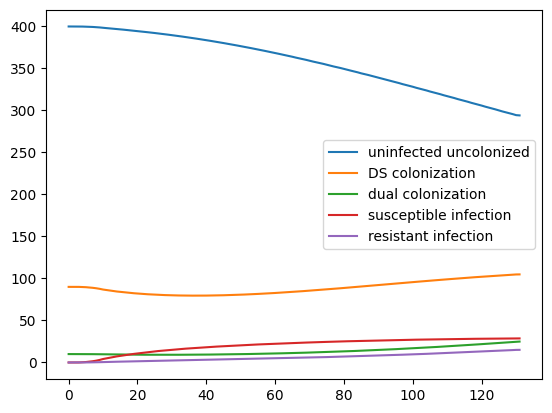

In [16]:
df.plot()